# 5. This notebook shows how to convert your final splittings into CO$_2$ density, and how to calculate P and depth
- Once you have your corrected splittings from step 1-4, you need to convert them into a densimeter developed for your instrument
- If you have a densimeter, you can either contact me and I can add it to the function, or you can write your own function using our function as a template

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
pf.__version__

'0.0.50'

## Read in data

In [2]:
df=pd.read_excel('Calibration_fitting_w_sec_phases.xlsx')
df.head()

,Unnamed: 0.1,Unnamed: 0,Corrected_Splitting,filename_x,Splitting,Diad1_Combofit_Cent,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,...,sec since midnight,Spectral Center,Ne_Correction,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb
0,0,0,102.835198,K21-59-FI#1,103.057281,1286.036078,590.183478,1286.036078,599.338630,0.435211,...,43795,1325.004,0.997845,K21-59-FI#1.txt,1151.160659,57.033468,26.540273,NaN,NaN,NaN
1,1,0,102.787877,K21-59-FI#2,103.010651,1286.157501,227.288998,1286.157501,200.266823,0.409698,...,44393,1325.004,0.997837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,102.822390,K21-59-FI#3,103.046189,1286.074236,570.010451,1286.074236,580.897805,0.422397,...,45146,1325.004,0.997828,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,103.085194,K21-61-FI#1-rep1,103.310515,1285.431591,65.483825,1285.431591,81.303002,0.574737,...,45944,1325.004,0.997819,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,103.078944,K21-61-FI#1-rep2,103.304596,1285.435781,607.688675,1285.435781,895.513299,0.568316,...,46247,1325.004,0.997816,K21-61-FI#1-rep2.txt,NaN,NaN,NaN,1090.889671,868.254585,43.035082


## Convert splitting to density
- Here we use the Cornell densimeter developed by DeVitre et al. (2021), and use the supercritical arguement, as analyses were done at 37C. 

In [3]:
densities=pf.calculate_density_cornell(temp='SupCrit', Split=df['Corrected_Splitting'])
densities.head()

,Preferred D,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature,Splitting,Preferred_D
0,0.043246,Y,"SupCrit, low density",0.037730,-0.391881,0.043246,0.045915,-0.363739,SupCrit,102.835198,NaN
1,0.025451,Y,"SupCrit, low density",0.020067,-0.436539,0.025451,0.029686,-0.408497,SupCrit,102.787877,NaN
2,0.038429,Y,"SupCrit, low density",0.032949,-0.403904,0.038429,0.041483,-0.375786,SupCrit,102.822390,NaN
3,0.137255,Y,"SupCrit, low density",0.131043,-0.166812,0.137255,0.137898,-0.138542,SupCrit,103.085194,NaN
4,0.134905,Y,"SupCrit, low density",0.128710,-0.172216,0.134905,0.135479,-0.143941,SupCrit,103.078944,NaN


## Calculate pressures using different equation of states and entrapment temps

### Using Span and Wanger, 1996 at 1150C

In [12]:
Pressure_SW96=pf.calculate_P_for_rho_T(T_K=1150+273.15,
                density_gcm3=densities['Preferred D'],
                 EOS='SW96')
Pressure_SW96.head()

,P_kbar,P_MPa,T_K,density_gcm3
0,0.119563,11.956315,1423.15,0.043246
1,0.069550,6.954958,1423.15,0.025451
2,0.105910,10.590985,1423.15,0.038429
3,0.405314,40.531364,1423.15,0.137255
4,0.397680,39.768006,1423.15,0.134905


### Using Sterner and Pitzer, 1994 at 1100 C

In [13]:
Pressure_SP94=pf.calculate_P_for_rho_T(T_K=1150+273.15,
                density_gcm3=densities['Preferred D'],
                 EOS='SW96')
Pressure_SP94.head()

,P_kbar,P_MPa,T_K,density_gcm3
0,0.119563,11.956315,1423.15,0.043246
1,0.069550,6.954958,1423.15,0.025451
2,0.105910,10.590985,1423.15,0.038429
3,0.405314,40.531364,1423.15,0.137255
4,0.397680,39.768006,1423.15,0.134905


## Lets convert these into depths in the crust
- DiadFit has various options for calculating depth, using the function 'convert_pressure_to_depth' 
1. Constant density
2. two-step density profile
3. three-step density profile
4. Crustal density models: 'ryan_lerner', 'mavko_debari', 'hill_zucca', 'prezzi,'rasmussen'

#### Constant crustal density of 2700 kg/m3

In [16]:
Depth_constant_rho=pf.convert_pressure_to_depth(P_kbar=Pressure_SW96['P_kbar'],
                crust_dens_kgm3=2700)
# Lets append this onto the dataframe above
Pressure_SW96['Depth_km_constantrho']=Depth_constant_rho
Pressure_SW96.head()

,P_kbar,P_MPa,T_K,density_gcm3,Depth_constantrho,Depth_km_constantrho
0,0.119563,11.956315,1423.15,0.043246,0.451403,0.451403
1,0.069550,6.954958,1423.15,0.025451,0.262580,0.262580
2,0.105910,10.590985,1423.15,0.038429,0.399856,0.399856
3,0.405314,40.531364,1423.15,0.137255,1.530236,1.530236
4,0.397680,39.768006,1423.15,0.134905,1.501416,1.501416


#### Two-step density, 2800 kg/m3 above moho at 17km, 3100 kg/m3 below

In [17]:
Depth_two_step=pf.convert_pressure_to_depth(P_kbar=Pressure_SW96['P_kbar'],
                model='two-step', rho1=2800, rho2=3100, d1=17)
# Lets append this onto the dataframe above
Pressure_SW96['Depth_km_2step']=Depth_two_step
Pressure_SW96.head()

,P_kbar,P_MPa,T_K,density_gcm3,Depth_constantrho,Depth_km_constantrho,Depth_km_2step
0,0.119563,11.956315,1423.15,0.043246,0.451403,0.451403,0.435282
1,0.069550,6.954958,1423.15,0.025451,0.262580,0.262580,0.253202
2,0.105910,10.590985,1423.15,0.038429,0.399856,0.399856,0.385575
3,0.405314,40.531364,1423.15,0.137255,1.530236,1.530236,1.475585
4,0.397680,39.768006,1423.15,0.134905,1.501416,1.501416,1.447794


#### Three step, 2400 kg/m3 down to 4km, 2800 down to 17 km, 3300 below that

In [18]:
Depth_three_step=pf.convert_pressure_to_depth(P_kbar=Pressure_SW96['P_kbar'],
model='three-step', rho1=2400, rho2=2800, rho3=3300, d1=4, d2=17)
# Lets append this onto the dataframe above
Pressure_SW96['Depth_km_3step']=Depth_three_step
Pressure_SW96.head()

,P_kbar,P_MPa,T_K,density_gcm3,Depth_constantrho,Depth_km_constantrho,Depth_km_2step,Depth_km_3step
0,0.119563,11.956315,1423.15,0.043246,0.451403,0.451403,0.435282,0.507829
1,0.069550,6.954958,1423.15,0.025451,0.262580,0.262580,0.253202,0.295403
2,0.105910,10.590985,1423.15,0.038429,0.399856,0.399856,0.385575,0.449838
3,0.405314,40.531364,1423.15,0.137255,1.530236,1.530236,1.475585,1.721516
4,0.397680,39.768006,1423.15,0.134905,1.501416,1.501416,1.447794,1.689093


#### Using the density model of ryan-lerner. 

In [20]:
Depth_RL=pf.convert_pressure_to_depth(P_kbar=Pressure_SW96['P_kbar'],
model='ryan_lerner')
# Lets append this onto the dataframe above
Pressure_SW96['Depth_km_RL']=Depth_RL
Pressure_SW96.head()

,P_kbar,P_MPa,T_K,density_gcm3,Depth_constantrho,Depth_km_constantrho,Depth_km_2step,Depth_km_3step,Depth_km_RL
0,0.119563,11.956315,1423.15,0.043246,0.451403,0.451403,0.435282,0.507829,0.550352
1,0.069550,6.954958,1423.15,0.025451,0.262580,0.262580,0.253202,0.295403,0.321552
2,0.105910,10.590985,1423.15,0.038429,0.399856,0.399856,0.385575,0.449838,0.488091
3,0.405314,40.531364,1423.15,0.137255,1.530236,1.530236,1.475585,1.721516,1.820375
4,0.397680,39.768006,1423.15,0.134905,1.501416,1.501416,1.447794,1.689093,1.787239


## Lets plot some of these depths and pressures
- We can make use of double axes to show pressure and depth for a given density model

Text(0, 0.5, '# of measurements')

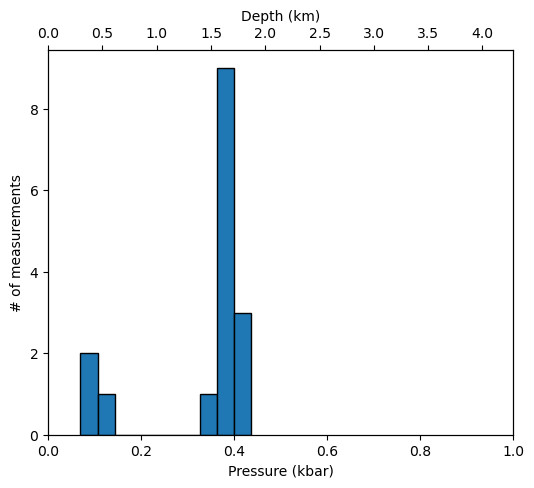

In [30]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6,5))
# ax1 is your primary axis, lets say this is pressure.
ax1.hist(Pressure_SW96['P_kbar'], ec='k')
# Set your pressure limits for x
Plim1=0
Plim2=1
ax1.set_xlim([Plim1, Plim2])

# now lets duplicate the x axis, so we can show depth at the top
ax2=ax1.twiny()


D_P1=pf.convert_pressure_to_depth(P_kbar=Plim1,model='ryan_lerner')
D_P2=pf.convert_pressure_to_depth(P_kbar=Plim2,model='ryan_lerner')
ax2.set_xlim([D_P1[0], D_P2[0]])
ax1.set_xlabel('Pressure (kbar)')
ax2.set_xlabel('Depth (km)')
ax1.set_ylabel('# of measurements')

## Propagating errors in calculated pressure
- The main source of random error are the CO$_2$ density and how well you have determined it using microthermometry or Raman spectroscopy
- Entrapment temp could be a random error, or systematic, depending on how well temperature is constrained in your system
- The crustal density and/or choice of density profile is more likely a systematic error. 

### Lets propagate uncertainty in just entrapment temperature to start with
- We say we have a +-50K absolute uncertainty in temperature, distributed normally

In [32]:
MC_Av_Tonly, MC_All_Tonly, fig=pf.loop_all_FI_MC(
T_K=1150+273.15, error_T_K=50, error_type_T_K='Abs', error_dist_T_K='normal', 
plot_figure=True)
MC_Av_Tonly.head()

TypeError: loop_all_FI_MC() missing 2 required positional arguments: 'sample_ID' and 'CO2_density_gcm3'

In [ ]:
MC_Av_Tonly, MC_All_Tonly, fig=pf.loop_all_FI_MC(
T_K=1150+273.15,
error_T_K=50, 
error_type_T_K='Abs', 
error_dist_T_K='normal',
CO2_density_gcm3=df['Density (g/cm^3)'],
error_CO2_dens=0.002925, error_type_CO2_dens='Abs', error_dist_CO2_dens='normal',
sample_ID=data['FileName'],
crust_dens_kgm3='two-step', d1=14, rho1=2800, rho2=3100,
N_dup=1000, fig_i=0, plot_figure=True)
MC_Av_Tonly.head()

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6,5))
         
sam0=data['SAMPLE']==0
sam1=data['SAMPLE']==2
sam4=data['SAMPLE']==4
sam6=data['SAMPLE']==6

ms=7
ax1.errorbar(data['Fo'].loc[sam0], 
             MC_Av_Tonly['SingleFI_D_km'].loc[sam0],
             xerr=0, yerr=MC_Av_Tonly['std_dev_MC_D_km'].loc[sam0],
             fmt='o', ecolor='k', elinewidth=0.8, mfc='red', ms=ms, mec='k', capsize=5)
ax1.errorbar(data['Fo'].loc[sam1], 
             MC_Av_Tonly['SingleFI_D_km'].loc[sam1],
             xerr=0, yerr=MC_Av_Tonly['std_dev_MC_D_km'].loc[sam1],
             fmt='^', ecolor='k', elinewidth=0.8, mfc='green', ms=ms, mec='k', capsize=5)

ax1.errorbar(data['Fo'].loc[sam4], 
             MC_Av_Tonly['SingleFI_D_km'].loc[sam4],
             xerr=0, yerr=MC_Av_Tonly['std_dev_MC_D_km'].loc[sam4],
             fmt='v', ecolor='k', elinewidth=0.8, mfc='blue', ms=ms, mec='k', capsize=5)
ax1.errorbar(data['Fo'].loc[sam6], 
             MC_Av_Tonly['SingleFI_D_km'].loc[sam6],
             xerr=0, yerr=MC_Av_Tonly['std_dev_MC_D_km'].loc[sam6],
             fmt='s', ecolor='k', elinewidth=0.8, mfc='orange', ms=ms, mec='k', capsize=5)
ax1.set_xlabel('Fo content')
ax1.set_ylabel('Depth (km)')
ax1.invert_yaxis()
ax2=ax1.twinx()
ax2.invert_yaxis()
Plim1=3.8
Plim2=8.1
ax2.set_ylim([Plim2, Plim1])
P_4kbar=pf.convert_pressure_depth_2step(P_kbar=Plim1, d1=14, rho1=2800, rho2=3100, g=9.81)
P_8kbar=pf.convert_pressure_depth_2step(P_kbar=Plim2, d1=14, rho1=2800, rho2=3100, g=9.81)
ax1.set_ylim([ P_8kbar, P_4kbar])